for more scope creep, using a 30 (or 60 or 90) day price plot estimate the most likley day that the stock will peak and use this as the sell date.


In [ ]:
import pandas as pd
from datetime import timedelta, time
#from datetime import datetime
import numpy as np
#import yfinance as yf
import matplotlib.pyplot as plt
#from pandas.tseries.offsets import BMonthEnd
#import pickle
import joblib
#from ta.momentum import RSIIndicator
#from ta.trend import MACD
import itertools
import xgboost as xgb
from sklearn import metrics
#from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
#from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, precision_recall_curve # Loading required libraries
from sklearn.inspection import permutation_importance

import openinsider_scraper as OIScraper
import features as ft

### Todo:

Go through indicators and make ABSOLUTLY SURE that there is no data leakage or look-ahead bias. There must be no training on data after the effective transaction date, as we are not supposed to know data from the after then.

Try testing all the features with the chi squared test to see if two variables are independent (the feature and the thing we want to predict) 

Hyper parameter tuning

Train a model on just the last year or 6 months oof data and make sure the 10y model and the 1 year model agree price go up


### Saving and loading varilabes with pickle, Joblib, and .save_model()

In [1]:
#os.makedirs('saved_vars', exist_ok=True)  # create folder if it doesn't exist

'''
Pickle
Saving a variable
'''
#with open('saved_vars/prices_for_all_tickers.pkl', 'wb') as f:
#    pickle.dump(prices, f)

'''
Loading a variable
'''
#with open('saved_vars/500_trades_from_mid_2024.pkl', 'rb') as f:  # 'rb' = read binary
#    data = pickle.load(f)

'''
JobLib
Saving a variable
'''
#Note: this took 2m 10s,  5m 30s,  for the 150k trades
#joblib.dump(df_by_ticker, 'saved_vars/All_features_and_prices_df.joblib')


'''
Loading a variable
'''
#variable = joblib.load('filename.joblib')

'''
Models, saving and loading
Saving an XGboost model
'''
# Save to file
#model.save_model("my_model.json")

'''
Loading a model
'''
#loaded_model = xgb.XGBClassifier()
#loaded_model.load_model("my_model.json")


'\nLoading a model\n'

In [ ]:
df = joblib.load('saved_vars/35_features_2015_21-10-2025.joblib')
# took 14 min last time

In [107]:
df_by_ticker = df.copy()
print(df_by_ticker.shape)
#remove rows with nans or neg nums in certain rows.
df_by_ticker = df_by_ticker.dropna()
df_by_ticker = df_by_ticker[(df_by_ticker[['last_price', 'Qty', 'shares_held', 'Owned', 'Value', 'Owned_norm', 'title_rank', 'filing_lad_days', 'same_day_trade_count']] >= 0).all(axis=1)]
print(df_by_ticker.shape)


(147685, 35)
(89412, 35)


In [19]:
#joblib.dump(df, 'saved_vars/All_features_and_prices_df.joblib')

['saved_vars/All_features_and_prices_df.joblib']

### Create target variable for price movement more than x%
#### True for increase, False for decrease.

In [ ]:
# Precompute the relevant indices
open_prices = df_by_ticker['future_prices'].apply(lambda df: df['Open'].iloc[0])
print('Retreived day 1 open prices')
next_day_close = df_by_ticker['future_prices'].apply(lambda df: df['Close'].iloc[0])
print('Retreived day 1 close prices')
one_week_close = df_by_ticker['future_prices'].apply(lambda df: df['Close'].iloc[5])
print('Retreived week 1 close prices')
one_month_close = df_by_ticker['future_prices'].apply(lambda df: df['Close'].iloc[20])
print('Retreived month 1 close prices')

# Define thresholds
thresholds = [1, 1.02, 1.05]

# Compute targets in a vectorised way
targets_dict = {}
for t in thresholds:
    targets_dict[f'next_day_{int((t-1)*100) if t != 1 else ""}%'] = next_day_close / open_prices > t
    targets_dict[f'one_week_{int((t-1)*100) if t != 1 else ""}%'] = one_week_close / open_prices > t
    targets_dict[f'one_month_{int((t-1)*100) if t != 1 else ""}%'] = one_month_close / open_prices > t

targets = pd.DataFrame(targets_dict)

del open_prices, next_day_close, one_week_close, one_month_close

## Key stats to beat 
### and facts about the target data.

In [24]:
prices = df_by_ticker['future_prices']
p = prices.apply(lambda df: df.iloc[0]['Close'] / df.iloc[0]['Open']) - 1




The following are shown as a proportion percentage (i.e. 1 = 100%)
Mean:  0.004620028030011639
Meadian:  0.0
Standard deviation:  0.13460457609128287
Min:  -0.6459999978542328
Max:  35.6666647264114



The following are shown as a proportion percentage (i.e. 1 = 100%)
These do not include trades that return more than 0.5 (50% increase)
Mean:  0.0032924041915549005
Meadian:  0.0
Standard deviation:  0.04626021539921731


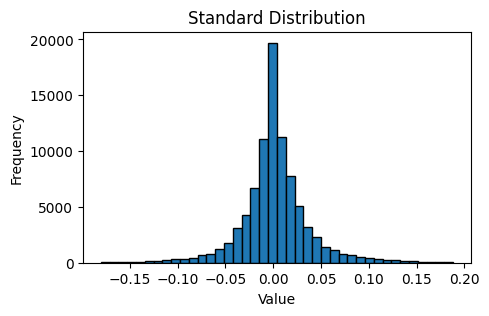

In [25]:

print('The following are shown as a proportion percentage (i.e. 1 = 100%)')
print('Mean: ', p.mean())
print('Meadian: ', p.median())
print('Standard deviation: ', p.std())
print('Min: ', p.min())
print('Max: ', p.max())


pp = p[p <= 0.5] # this removes the top 100 trades
pp = pp[pp >= -0.5] # this removes the bottom ~5 trades



print('\n\n\nThe following are shown as a proportion percentage (i.e. 1 = 100%)')
print('These do not include trades that return more than 0.5 (50% increase)')
print('Mean: ', pp.mean())
print('Meadian: ', pp.median())
print('Standard deviation: ', pp.std())




plt.figure(figsize=(5,3))
plt.hist(pp[abs(pp - pp.mean()) <= 4 * pp.std()], bins=40, edgecolor='black')
plt.title('Standard Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [26]:
targ = targets['next_day_2%']
length = len(targ)
print('Percentage proportion that go up at least 2%: ', targ.sum()/length)
print('prop that dont: ', 1 -targ.sum()/length )
print()

targ = targets['next_day_5%']
length = len(targ)
print('Percentage proportion that go up at least 5%: ', targ.sum()/length)
print('prop that dont: ', 1 -targ.sum()/length )


Percentage proportion that go up at least 2%:  0.22005189154892874
prop that dont:  0.7799481084510713

Percentage proportion that go up at least 5%:  0.08027328038431471
prop that dont:  0.9197267196156853


## Prediction 1 day higher (1) lower (0) price movements 


### (think about making that higher or lower than a x% increase, whatever the cut off is)


## Random Forest Classifier

In [ ]:
y = targets['next_day_2%']

'''
The following are removed:
Dates: 
ticker, company_name, owner_name: The characters in a name should not matter. 
prev_prices, future_prices: These were only used to create other variables
Title: represented as a number in title_rank
transaction_type: all the same, P - Purchase.
Owned: Now using Owned_norm to deal with the 'New' values in Owned.

'''

X = df_by_ticker.drop([
    'transaction_date', 'trade_date', 'eff_trans_date', 
    'ticker','company_name', 'owner_name', 'prev_prices', 'future_prices', 
    'Title', 'transaction_type', 'Owned','trade_date_epoch', 'eff_trans_date_epoch', 'day_of_week'
    ], axis=1)

print('Keeping Columns: ', X.columns)

#
#Testing weather the random splitting is causeing data leakage.
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Spliting Train Test datasets

#Instead we'll use this 
# Example: 80/20 time split by eff_trans_date
split_date = df_by_ticker['eff_trans_date'].quantile(0.9)
train_idx = df_by_ticker['eff_trans_date'] <= split_date
X_train = X.loc[train_idx]
y_train = y.loc[train_idx]
X_test = X.loc[~train_idx]
y_test = y.loc[~train_idx]

Keeping Columns:  Index(['last_price', 'Qty', 'shares_held', 'Value', 'Owned_norm', 'title_rank',
       'SPY_1d_return', 'is_during_market_hours', '1mo_return', '3mo_return',
       '30d_volatility', 'rsi_14', 'macd', 'volume_zscore', 'price_vs_sma50',
       'day_of_week', 'filing_lad_days', 'month_end_flag'],
      dtype='object')


In [183]:
#Note: with 88k trades it took 15.8 sec

clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_leaf_nodes=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

Accuracy:  0.7667423382519863

Feature Importance
30d_volatility            0.109589
3mo_return                0.084819
volume_zscore             0.079056
SPY_1d_return             0.076596
price_vs_sma50            0.075937
last_price                0.073816
1mo_return                0.073408
macd                      0.070943
rsi_14                    0.070148
Value                     0.058414
Qty                       0.055316
shares_held               0.054952
Owned_norm                0.032759
filing_lad_days           0.029733
day_of_week               0.023994
title_rank                0.016875
is_during_market_hours    0.007560
month_end_flag            0.006085
dtype: float64

Feature Importance accounting for correlated features
rsi_14                    0.003280
macd                      0.001192
is_during_market_hours    0.000522
shares_held               0.000499
SPY_1d_return             0.000409
title_rank                0.000284
month_end_flag            0.000136
30d_v

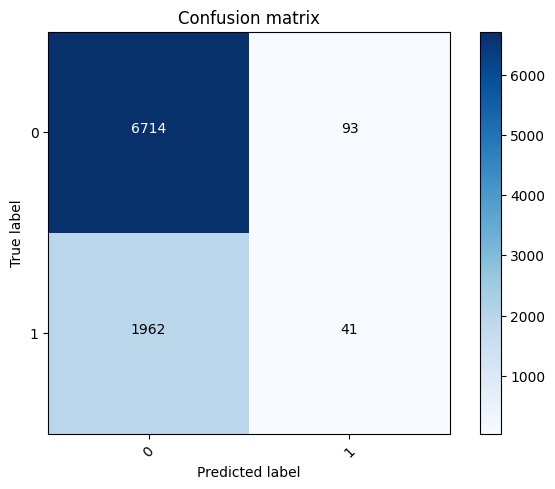

In [184]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = clf.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 
# Confusion Matrix 



importances = clf.feature_importances_
feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print('')
print('Feature Importance')
print(feature_importance)


result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)
perm_importance = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
print()
print('Feature Importance accounting for correlated features')
print(perm_importance)

In [20]:
# a shit way to show return

predicted_trues = X_test[y_pred]
prices = df_by_ticker.loc[predicted_trues.index]['future_prices']
percentage_returns = prices.apply(lambda df: df.iloc[0]['Close'] / df.iloc[0]['Open'])
x = percentage_returns-1

print('Average return', x.mean())

print('\nTake profit.')
print('Av percentage prop between Open and high', )

NameError: name 'X_test' is not defined

## XGBoost

Detail about how to use XGBoost
https://gist.github.com/pb111/cc341409081dffa5e9eaf60d79562a03 

#### Analysis defs

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Initial model

In [27]:
y = targets['next_day_2%']

'''
The following are removed:
Dates: 
ticker, company_name, owner_name: The characters in a name should not matter. 
prev_prices, future_prices: These were only used to create other variables
Title: represented as a number in title_rank
transaction_type: all the same, P - Purchase.
Owned: Now using Owned_norm to deal with the 'New' values in Owned.

'''

X = df_by_ticker.drop([
    'transaction_date', 'trade_date', 'eff_trans_date', 
    'ticker','company_name', 'owner_name', 'prev_prices', 'future_prices', 
    'Title', 'transaction_type', 'Owned','trade_date_epoch', 'eff_trans_date_epoch',
    'day_of_week'
    ], axis=1)

print('Keeping Columns: ', X.columns)

#
#Testing weather the random splitting is causeing data leakage.
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Spliting Train Test datasets

#Instead we'll use this 
# Example: 80/20 time split by eff_trans_date
split_date = df_by_ticker['eff_trans_date'].quantile(0.9)
train_idx = df_by_ticker['eff_trans_date'] <= split_date
X_train = X.loc[train_idx]
y_train = y.loc[train_idx]
X_test = X.loc[~train_idx]
y_test = y.loc[~train_idx]

print('Number of trues: ', len(y_test[y_test==1]))
print('Number of fales: ', len(y_test[y_test==0]))
print('Percentage of faleses: ', len(y_test[y_test==0])/(len(y_test[y_test==0]) + len(y_test[y_test==1])))
print()
print()
print()


#Note: with 88k trades it took 
# XGBoost classifier
clf = xgb.XGBClassifier(
    n_estimators=90,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Keeping Columns:  Index(['last_price', 'Qty', 'shares_held', 'Value', 'Owned_norm', 'title_rank',
       'SPY_1d_return', 'is_during_market_hours', '1mo_return', '3mo_return',
       '30d_volatility', 'rsi_14', 'macd', 'volume_zscore', 'price_vs_sma50',
       'filing_lad_days', 'month_end_flag', 'same_day_trade_count', 'day_sin',
       'day_cos'],
      dtype='object')
Number of trues:  2003
Number of fales:  6807
Percentage of faleses:  0.7726447219069239





c:\Users\azzag\Documents\Programming\Python\TradingBot\botenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:57:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7693530079455164


#### Training toward precision on positive price up rather than general accuracy.

Index(['Qty', 'shares_held', 'Value', 'Owned_norm', 'title_rank',
       'SPY_1d_return', 'is_during_market_hours', '1mo_return', '3mo_return',
       '30d_volatility', 'rsi_14', 'macd', 'volume_zscore', 'price_vs_sma50',
       'filing_lad_days', 'month_end_flag', 'same_day_trade_count', 'day_sin',
       'day_cos'],
      dtype='object')
Number of trues:  1625
Number of fales:  15888
Percentage of faleses:  0.9072117855307485



Min prob: 0.00031375463 Max prob: 0.9372446
Threshold: 0.735
Precision: 0.2481527093596059  How many of the predicted up days were correct.
Recall: 0.248  How many up days were predicted as a proportion.
Accuracy: 0.8605036258779193


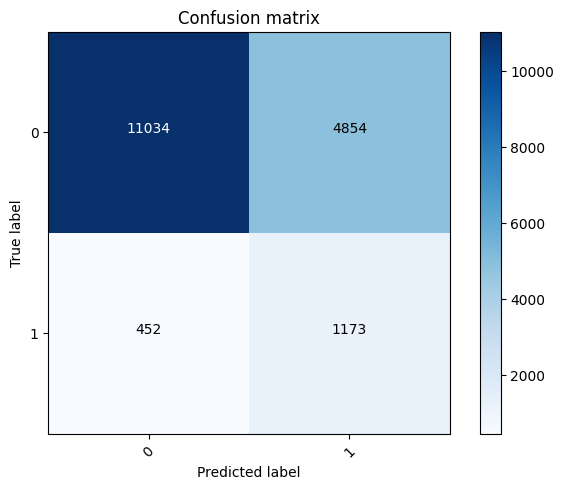

In [77]:
y = targets['next_day_5%']
'''
X = df_by_ticker.drop([
    'transaction_date', 'trade_date', 'eff_trans_date', 'ticker','company_name', 'owner_name', 'prev_prices', 'future_prices', 
    'Title', 'transaction_type', 'Owned','trade_date_epoch', 'eff_trans_date_epoch', '30d_volatility', 'title_rank', 'filing_lad_days', 
    'Owned_norm', 'last_price', 'SPY_1d_return', 'is_during_market_hours', 'day_of_week', 'month_end_flag', 'Value', '1mo_return', 'shares_held',  'Qty', 'volume_zscore'
], axis=1)'''

X = df_by_ticker.drop([
    'transaction_date', 'trade_date', 'eff_trans_date', 
    'ticker','company_name', 'owner_name', 'prev_prices', 'future_prices', 
    'Title', 'transaction_type', 'Owned','trade_date_epoch', 'eff_trans_date_epoch',
    'day_of_week', 'last_price'
    ], axis=1)
print(X.columns)

split_date = df_by_ticker['eff_trans_date'].quantile(0.8)
train_idx = df_by_ticker['eff_trans_date'] <= split_date
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[~train_idx], y.loc[~train_idx]

print('Number of trues: ', len(y_test[y_test==1]))
print('Number of fales: ', len(y_test[y_test==0]))
print('Percentage of faleses: ', len(y_test[y_test==0])/(len(y_test[y_test==0]) + len(y_test[y_test==1])))
print()
print()
print()


pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

clf = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=pos_weight,  # bias gradient toward positive class
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Examine range of probabilities
print("Min prob:", y_pred_proba.min(), "Max prob:", y_pred_proba.max())

from sklearn.metrics import precision_recall_curve
prec, rec, th = precision_recall_curve(y_test, y_pred_proba)
prec, rec, th = prec[:-1], rec[:-1], th  # drop last precision/recall to match thresholds

# Filter for thresholds that still yield some recall
valid = rec > 0
prec = prec[valid]
rec = rec[valid]
th = th[valid]

# Choose threshold where precision >= recall (balanced conservatism)
import numpy as np
idx = np.argmax(prec >= rec)
chosen_threshold = th[idx] if len(th) > 0 else 0.5

y_pred = (y_pred_proba > chosen_threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, accuracy_score
print(f"Threshold: {chosen_threshold:.3f}")
print("Precision:", precision_score(y_test, y_pred), ' How many of the predicted up days were correct.')
print("Recall:", recall_score(y_test, y_pred), ' How many up days were predicted as a proportion.') 
print("Accuracy:", accuracy_score(y_test, y_pred))



y_pred = clf.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred) 
#print(confusion_mtx)
plot_confusion_matrix(confusion_mtx, classes = range(2)) 


## Determining stop loss and take profit.

Average return:  0.011607731027883561

Take profit.
Av percentage prop between Open and high:  0.06310092913232884
Standard dev:  0.12840136564018215
25% of values are above: 0.07762023364778059
50% of values are above (median): 0.038043480901671534
75% of values are above: 0.011857696335581869


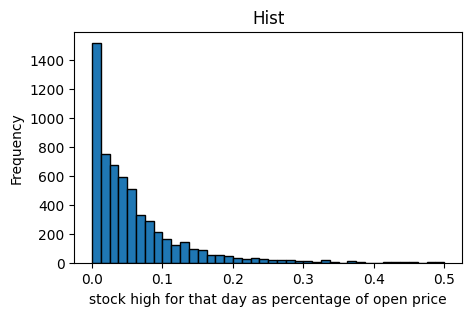


Take profit.
Av percentage prop between Open and low:  -0.04317431821971265
Standard dev:  0.05175732034793812
25% of values are below: -0.05882353198982032
50% of values are below (median): -0.02954387110666301
75% of values are below: -0.009950239314132636


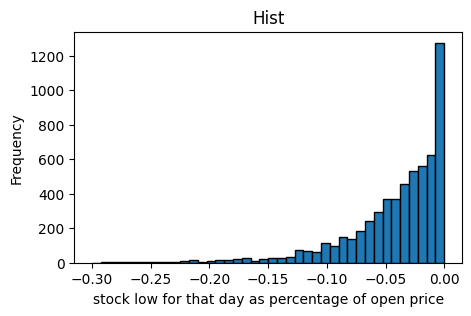

In [61]:
# Av Return, stop loss, take profit.

predicted_trues = X_test[y_pred==1]
prices = df_by_ticker.loc[predicted_trues.index]['future_prices']
close_over_open = prices.apply(lambda df: df.iloc[0]['Close'] / df.iloc[0]['Open'])
high_over_open = prices.apply(lambda df: df.iloc[0]['High'] / df.iloc[0]['Open'])
low_over_open = prices.apply(lambda df: df.iloc[0]['Low'] / df.iloc[0]['Open'])

x = close_over_open-1
print('Average return: ', x.mean())

x = high_over_open-1
print('\nTake profit.')
print('Av percentage prop between Open and high: ', x.mean())
print('Standard dev: ',  x.std())
print('25% of values are above:', x.quantile(0.75))
print('50% of values are above (median):', x.quantile(0.5))
print('75% of values are above:', x.quantile(0.25))

plt.figure(figsize=(5,3))
#plt.hist(x, bins=40, edgecolor='black')
plt.hist(x[x <= 0.5], bins=40, edgecolor='black')
plt.title('Hist')
plt.xlabel('stock high for that day as percentage of open price')
plt.ylabel('Frequency')
plt.show()


x = low_over_open-1
print('\nTake profit.')
print('Av percentage prop between Open and low: ', x.mean())
print('Standard dev: ',  x.std())
print('25% of values are below:', x.quantile(0.25))
print('50% of values are below (median):', x.quantile(0.5))
print('75% of values are below:', x.quantile(0.75))

plt.figure(figsize=(5,3))
#plt.hist(x, bins=40, edgecolor='black')
plt.hist(x[x >= -0.3], bins=40, edgecolor='black')
plt.title('Hist')
plt.xlabel('stock low for that day as percentage of open price')
plt.ylabel('Frequency')
plt.show()

Now looking at just the profitable trades (return > 0%) that were predicted trues.

(2947,)

Take profit.
Av percentage prop between Open and low:  0.10126129202439335
Standard dev:  0.1680049715430828
25% of values are above: 0.1197050436401611
50% of values are above (median): 0.06896555622182587
75% of values are above: 0.04081628681073313


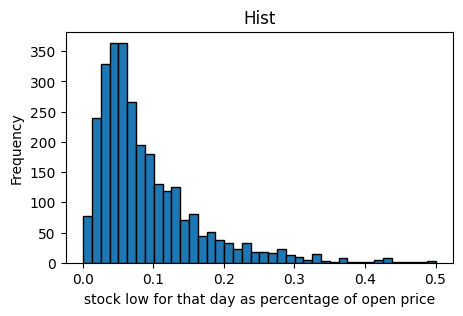


Take profit.
Av percentage prop between Open and low:  -0.022353244616226144
Standard dev:  0.029163497666216617
25% of values are below: -0.0303689223622699
50% of values are below (median): -0.014388475634778741
75% of values are below: -0.00288845976910157


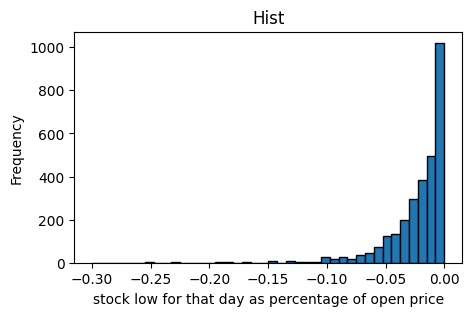

In [67]:
#predicted_trues = X_test[y_pred==1]
prices_rnt_profitable = prices[close_over_open > 1]

high_over_open_profitable = prices_rnt_profitable.apply(lambda df: df.iloc[0]['High'] / df.iloc[0]['Open'])
print(high_over_open_profitable.shape)
x = high_over_open_profitable-1
print('\nTake profit.')
print('Av percentage prop between Open and low: ', x.mean())
print('Standard dev: ',  x.std())
print('25% of values are above:', x.quantile(0.75))
print('50% of values are above (median):', x.quantile(0.5))
print('75% of values are above:', x.quantile(0.25))

plt.figure(figsize=(5,3))
#plt.hist(x, bins=40, edgecolor='black')
plt.hist(x[x <= 0.5], bins=40, edgecolor='black')
plt.title('Hist')
plt.xlabel('stock low for that day as percentage of open price')
plt.ylabel('Frequency')
plt.show()






low_over_open_profitable = prices_rnt_profitable.apply(lambda df: df.iloc[0]['Low'] / df.iloc[0]['Open'])
x = low_over_open_profitable-1
print('\nTake profit.')
print('Av percentage prop between Open and low: ', x.mean())
print('Standard dev: ',  x.std())
print('25% of values are below:', x.quantile(0.25))
print('50% of values are below (median):', x.quantile(0.5))
print('75% of values are below:', x.quantile(0.75))

plt.figure(figsize=(5,3))
#plt.hist(x, bins=40, edgecolor='black')
plt.hist(x[x >= -0.3], bins=40, edgecolor='black')
plt.title('Hist')
plt.xlabel('stock low for that day as percentage of open price')
plt.ylabel('Frequency')
plt.show()

#### Permutation importance

If score is negative then this implies the feature is only adding noise to the model



In [311]:
#result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)
#perm_importance = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
#print('Feature Importance accounting for correlated features')
#print(perm_importance)

6878.741407123799 % return
Average return proportion %:  0.011607731027883561


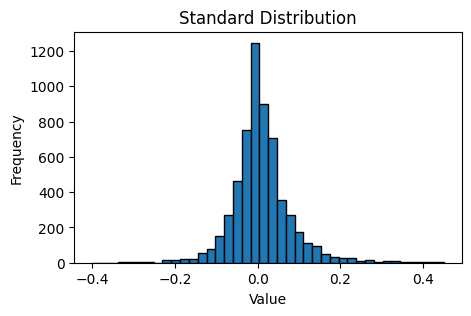

In [36]:
# a shit way to show return

predicted_trues = X_test[y_pred==1]
prices = df_by_ticker.loc[predicted_trues.index]['future_prices']
percentage_returns = prices.apply(lambda df: df.iloc[0]['Close'] / df.iloc[0]['Open'])


x = percentage_returns-1
#print(x)
print(x.sum()*100, '% return')
print('Average return proportion %: ', x.mean())



### For step wise removal of features

Keeping Columns:  Index(['3mo_return', 'rsi_14', 'macd', 'price_vs_sma50'], dtype='object')
Accuracy: 0.7627476731570834


c:\Users\azzag\Documents\Programming\Python\TradingBot\botenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Feature Importance accounting for correlated features
price_vs_sma50    0.015794
rsi_14            0.009444
macd              0.008285
3mo_return        0.004825
dtype: float64


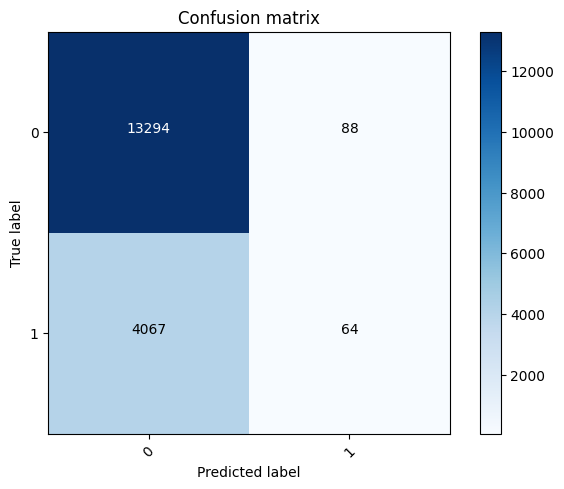

In [223]:
X = df_by_ticker.drop([
    'transaction_date', 'trade_date', 'eff_trans_date', 
    'ticker','company_name', 'owner_name', 'prev_prices', 'future_prices', 
    'Title', 'transaction_type', 'Owned','trade_date_epoch', 'eff_trans_date_epoch',
    # Below are all the features remove due to unimportance in order.
    '30d_volatility', 'title_rank', 'filing_lad_days', 'Owned_norm', 'last_price',
    'SPY_1d_return', 'is_during_market_hours', 'day_of_week', 'month_end_flag',
    'Value', '1mo_return', 'shares_held',  'Qty', 'volume_zscore'
    ], axis=1)

print('Keeping Columns: ', X.columns)

#
#Testing weather the random splitting is causeing data leakage.
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Spliting Train Test datasets

#Instead we'll use this 
# Example: 80/20 time split by eff_trans_date
split_date = df_by_ticker['eff_trans_date'].quantile(0.8)
train_idx = df_by_ticker['eff_trans_date'] <= split_date
X_train = X.loc[train_idx]
y_train = y.loc[train_idx]
X_test = X.loc[~train_idx]
y_test = y.loc[~train_idx]


#Note: with 88k trades it took 
# XGBoost classifier
clf = xgb.XGBClassifier(
    n_estimators=90,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = clf.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 
# Confusion Matrix 



result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)
perm_importance = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
print()
print('Feature Importance accounting for correlated features')
print(perm_importance)

### Model Analysis 

#### To be moved to another file eventually.

#### Inputs:

A pd df that contains the cols: `eff_trans_date, buy_price, sell_price, buy_date, sell_date`.

Starting Capital (dollars)

#### Output:

A pd df that contains the cols: `av_annual_returns, `. More to be added.

In [72]:
# Break up into years
# do this by iso eff_tras_date year and create a group, then run a bool mask if trade.year == years[i]

# Then for each year you run the profit loss calc and record buy, sell, profit/loss percentage, annual return, num_of_wins, num_of_losses, ratio_wins_losses.
#variables to pass into function.
starting_balance = 10000
days_between_buy_sell = 0 #same day = 0, one week = 5, one month = 20
predicted_trues = X_test[y_pred==1]
pred_trades = df_by_ticker.loc[predicted_trues.index]
stop_loss = -0.03 # as proportion, a 3% stop loss is 0.03
take_profit = 10


'''
Inside func
'''

trades = pd.DataFrame()
trades['eff_trans_date'] = pred_trades['eff_trans_date']
trades['buy'] = pred_trades['future_prices'].apply(lambda df: df['Open'].iloc[0])
trades['sell'] = pred_trades['future_prices'].apply(lambda df: df['Close'].iloc[days_between_buy_sell])
trades['buy_date'] = pred_trades['future_prices'].apply(lambda df: df.index[0])
trades['sell_date'] = pred_trades['future_prices'].apply(lambda df: df.index[days_between_buy_sell])
trades['returns_prop'] = trades.apply(lambda trade: trade['sell'] / trade['buy'] - 1,  axis = 1) #Proportion from 0 to 1, not percentage from 0 to 100%.
trades['balance'] = pd.NA

years = pd.Series(list(set(trades['eff_trans_date'].dt.year))).sort_values() #creates a set of the years in df, converts to series. 
years.index = range(len(years))

#start for loop
#df_2015 = trades[trades['eff_trans_date'].dt.year == years.iloc[0]] #replace 0 with i in forloop

trades.loc[trades.index[0], 'balance'] = starting_balance + (trades.loc[trades.index[0], 'returns_prop']) * (starting_balance / 10) #take 10% of start bal, * with returns percent, add profit to start bal

for j in range(1, len(trades)):

    percent_change = trades.loc[trades.index[j], 'returns_prop']
    
    if percent_change > take_profit:
        percent_change = take_profit
    elif percent_change < stop_loss:
        percent_change = stop_loss
    
    trades.loc[trades.index[j], 'balance'] = (percent_change) * (trades.loc[trades.index[j-1], 'balance'] / 10) + trades.loc[trades.index[j-1], 'balance']
    #print('Balance for trade ', j, ':', trades.loc[trades.index[j], 'balance'])




print(trades.iloc[-1])

eff_trans_date    2024-12-31 00:00:00
buy                             18.18
sell                            18.17
buy_date          2025-01-02 00:00:00
sell_date         2025-01-02 00:00:00
returns_prop                 -0.00055
balance             2227291246.909821
Name: 139763, dtype: object


In [76]:
starting_balance = 10000
days_between_buy_sell = 0
stop_loss = -0.03
take_profit = 0.1
bet_fraction = 0.1

# Trades DataFrame construction (your existing code here)
trades = pd.DataFrame()
trades['eff_trans_date'] = pred_trades['eff_trans_date']
trades['buy'] = pred_trades['future_prices'].apply(lambda df: df['Open'].iloc[0])
trades['sell'] = pred_trades['future_prices'].apply(lambda df: df['Close'].iloc[days_between_buy_sell])
trades['buy_date'] = pred_trades['future_prices'].apply(lambda df: df.index[0])
trades['sell_date'] = pred_trades['future_prices'].apply(lambda df: df.index[days_between_buy_sell])
trades['returns_prop'] = trades.apply(lambda r: r['sell']/r['buy'] - 1, axis=1)
trades = trades.sort_values('eff_trans_date').reset_index(drop=True)

# Cap returns
trades['returns_capped'] = trades['returns_prop'].clip(lower=stop_loss, upper=take_profit)

# Balance update
balances = [starting_balance]
for r in trades['returns_capped']:
    prev_balance = balances[-1]
    profit = prev_balance * bet_fraction * r
    balances.append(prev_balance + profit)
trades['balance'] = balances[1:]

# Summary
trades['win'] = trades['returns_capped'] > 0
trades['loss'] = ~trades['win']
trades['profit_pct'] = trades['returns_capped'] * 100

summary = trades.groupby(trades['eff_trans_date'].dt.year).agg(
    start_balance=('balance', 'first'),
    end_balance=('balance', 'last'),
    num_trades=('returns_capped', 'size'),
    wins=('win', 'sum'),
    losses=('loss', 'sum'),
    avg_return=('returns_capped', 'mean')
)
summary['annual_return_%'] = (summary['end_balance']/summary['start_balance'] - 1) * 100
summary['win_loss_ratio'] = summary['wins'] / summary['losses']
print(summary)

                start_balance   end_balance  num_trades  wins  losses  \
eff_trans_date                                                          
2023             10028.165378  5.571470e+05        2988  1530    1458   
2024            556849.095130  2.613528e+07        2938  1417    1521   

                avg_return  annual_return_%  win_loss_ratio  
eff_trans_date                                               
2023              0.013547      5455.822157        1.049383  
2024              0.013196      4593.422409        0.931624  


## chat response to data leakage

### This one I'm not sure about, I only get the data on the transaction date (SEC filing date) and make a prediction for the day after, meaning I can just wait until market close to gather all OHLCV data for the transaction date. The logic for eff_trans_date is sound and the comments was wrong, 9:30 am is market open and SEC filings (transaction dates) are effectivly treated as filings from the day before. I think I can use data from the day of the trans date because I will always be waiting for market close and then acting on predictions the day after

Chat:

2) Prev_prices / feature window may include data from the filing day (possible leakage) — cell 12 (get_ticker_data_from_cache) and cell 18 (create_features)
- What I found:
  - In cell 12: prev_price = ticker_prices.loc[trade['eff_trans_date'] - timedelta(days=100):trade['eff_trans_date']]
  - create_features (cell 18) computes indicators (RSI, MACD, moving averages) from ticker_data which is `prev_prices`.
- Why it's a problem: If `ticker_prices` are daily OHLCV (one row per trading day) and `eff_trans_date` is a date that corresponds to a day when filing happened during market hours, then `ticker_prices.loc[..., eff_trans_date]` can include the same-day open/close that occurred after the filing. That would leak post-filing price information into features.
- Two issues inside this:
  a) The logic that computes `eff_trans_date` (cell 5) uses an adjust based on time; it's inconsistent with comments (9 vs 9:30) and may not ensure the prev window excludes intra-day data recorded after the filing.
  b) Using a slice that ends at `eff_trans_date` is brittle: better to end the prev window at the last available price strictly before the filing timestamp (transaction_date).
- Fix: choose the last price index strictly before `transaction_date` (not `eff_trans_date`) and compute prev window up to that last index. For daily data, that typically means using the last trading day whose timestamp < transaction_date.

Suggested code replacement for `get_ticker_data_from_cache` (robust approach):


In [ ]:
def get_ticker_data_from_cache(trade):
    ticker_prices = prices[trade['ticker']]

    # Ensure both indexes and transaction_date are timezone-naive datetimes
    trans_dt = pd.to_datetime(trade['transaction_date'])
    # find the last price index strictly before the filing timestamp
    prior_indices = ticker_prices.index[ticker_prices.index.to_series() < trans_dt]
    if prior_indices.empty:
        # fallback: use earliest available or NaN
        last_idx = ticker_prices.index.min()
    else:
        last_idx = prior_indices.max()

    # take N days back from last_idx
    prev_start = last_idx - timedelta(days=100)
    prev_price = ticker_prices.loc[prev_start:last_idx]

    # for future prices start from the next index after last_idx
    future_indices = ticker_prices.index[ticker_prices.index.to_series() > last_idx]
    if future_indices.empty:
        future_price = pd.DataFrame()  # or NaN; handle downstream
    else:
        next_idx = future_indices.min()
        future_price = ticker_prices.loc[next_idx: next_idx + timedelta(days=35)]

    return {'ticker': trade['ticker'], 'prev_prices': prev_price, 'future_prices': future_price}

- This guarantees features built from `prev_prices` use only prices strictly before the filing timestamp.

3) eff_trans_date calculation and ambiguous cutoff — cell 5 (adjust_transaction_date)
- What I found: adjust_transaction_date(dt) checks if dt.hour < 9 or (dt.hour == 9 and dt.minute < 30) then return dt - 1 date; else return dt.date(). Comments mention "9am" in text but code uses 9:30 — a mismatch and possible logic errors.
- Why it's a problem: If you mis-classify which day a filing "belongs" to you may include the wrong rows in prev_prices or future_prices (e.g., including the filing day's open in prev_prices when you intended not to).
- Fix: be explicit and consistent: decide the exact cut (9:30 is the market open time in US markets). Use `transaction_date` (datetime) for strict comparisons (not eff_trans_date) when selecting prior prices. Add tests to check boundary cases (e.g., filing at 9:29:59 vs 9:30:01).

Suggested clarification:


In [ ]:
# Use market open 9:30 as the cutoff consistently
MARKET_OPEN = time(9, 30)
def adjust_transaction_date(dt):
    dt = pd.to_datetime(dt)
    if dt.time() < MARKET_OPEN:
        return (dt - pd.Timedelta(days=1)).date()
    return dt.date()

### I tested if SPY was effecting things by removing it completely and it did not meaningfuly effect it.

4) Merging SPY returns on `eff_trans_date` may introduce leakage if eff_trans_date misalignment exists — cell 18
- What I found: spy_returns = (spy_history['Close']/spy_history['Open'] - 1).rename('SPY_1d_return') and then df_by_ticker = df_by_ticker.merge(spy_returns, left_on='eff_trans_date', right_index=True, how='left').
- Why it's a problem: If eff_trans_date refers to a date when filing occurs midday, merging daily SPY open/close for that same date may include intraday movement after the filing. Again, you should merge a SPY feature that is strictly prior to the filing timestamp (e.g., SPY return for the last completed trading day before the filing).
- Fix: derive spy feature using the same rule as prev_prices: find the SPY row whose timestamp is the last trading day strictly before `transaction_date` (or `last_idx` computed earlier), and use that single value per trade.

Example change idea:
- When you compute `last_idx` for the ticker in get_ticker_data_from_cache, also lookup SPY return at `last_idx` and assign it as SPY_1d_return for that row (no global merge needed). This avoids misalignment and keeps the SPY feature strictly prior to the filing.

5) You include epoch/time features but drop date strings — potential leaking via time features — cell 18 + 27
- What I found: create_features sets 'trade_date_epoch' and 'eff_trans_date_epoch' and then you later drop the `eff_trans_date` column but not `eff_trans_date_epoch` when forming X (cell 27: X = df_by_ticker.drop([... 'eff_trans_date', ...], axis=1)).
- Why it's a problem: `*_epoch` encodes the absolute time of the event, which implicitly gives the model information about calendar time (and with a random split the model can use that to cheat — e.g., if you train on 2018–2022 and test on 2016–2017 but randomly split the numeric epoch values will be mixed).
- Fix:
  - If you use time-based split then epoch can be legitimate as a feature because the model will only see earlier times in training and later in testing.
  - If you continue to use random splitting, drop epoch features or remove any features that encode the absolute future date. In general prefer relative time features (age since some event) instead of absolute epoch or enforce temporal splitting.



Other lower-risk issues / notes

- Using `ticker_data['Close'].iloc[-1] / ticker_data['Close'].iloc[-22]` for returns assumes there are >=22 rows; if prev window has missing days this can reference wrong indices. You already later do dropna; but better to guard with explicit checks and fallback behavior.
- The indicator calculations (RSI, MACD) use the end of `ticker_data`. After you correct prev window to end at last pre-filing index these are OK.
- `predicted_trues = X_test[y_pred]` (cell 31): you're indexing X_test rows using y_pred; that works but be careful mixing indices — verify indices align. Not a leakage issue per se, but a correctness/edge-case bug source (you later drop index 105200 because "all prices are negative" — investigate rather than hard-dropping an index).
- Timezones: make sure `ticker_prices` index and `transaction_date` are timezone-naive or consistently timezone-aware before comparisons. You remove tz with tz_localize(None) in one place for `eff_trans_date`, but ensure consistency when comparing datetimes.

Short checklist of concrete edits I'd apply (if you want me to update the notebook)
- [ ] Replace `get_ticker_data_from_cache` (cell 12) with logic that finds last price index strictly before `transaction_date` and builds prev/future windows relative to that index. (Code snippet above.)
- [ ] Replace the global merge of `spy_returns` (cell 18) with per-row lookup tied to the last pre-filing price date (or ensure the merged date is the prior trading day).
- [ ] Replace random train_test_split (cell 27) with a time-based split or TimeSeriesSplit. Add a small function to make splits reproducible and chronological.
- [ ] Remove or carefully handle absolute epoch features if you plan to keep random splitting; otherwise keep epochs but use time-split.
- [ ] Add tests / assertions for boundary filing times (exactly at 9:30, at midnight, etc.) so adjust_transaction_date is behaving as intended.
- [ ] Replace blind `dropna()` with a diagnostics cell that prints counts and reasons for NaNs before removing rows.

Would you like me to:
- 1) implement the three core fixes above (prev_price slicing, SPY alignment, and time-based train/test split) directly in analysis.ipynb and run a quick smoke check for obvious errors; or
- 2) just produce a small standalone patch / snippet you can paste in?

If you want me to edit the notebook, I will:
- make the changes,
- run lightweight checks (no heavy retrain),
- report what changed and any outputs/errors.

Which do you prefer?